## Problem 1: The Mauna Loa CO2 Concentration

In 1958, Charles David Keeling (1928-2005) from the Scripps Institution of Oceanography began recording carbon dioxide (CO2) concentrations in the atmosphere at an observatory located at about 3,400m altitude on the Mauna Loa Volcano on Hawaii Island. The location was chosen because it is not influenced by changing CO levels due to the local vegetation and because prevailing wind patterns on this tropical island tend to bring well-mixed air to the site. While the recordings are made near a volcano (which tends to produce CO2), wind patterns tend to blow the volcanic CO away from the recording site. Air samples are taken several times a day, and concentrations have been observed using the same measuring method for over 60 years. In addition, samples are stored in flasks and periodically reanalyzed for calibration purposes. The observational study is now run by Ralph Keeling, Charles's son. The result is a data set with very few interruptions and very few inhomogeneities. It has been called the “most important data set in modern climate research."

The data set for this problem can be found in `CO2.csv`. It provides the concentration of CO2 recorded at Mauna Loa for each month starting March 1958. More description is provided in the data set file. We will be considering only the CO2 concentration given in column 5. The goal of the problem is to fit the data and understand its variations. You will encounter missing data points; part of the exercise is to deal with them appropriately.

Let $C_i$ be the average CO2 concentration in month $i$ ($i = 1,2,\dots$, counting from March 1958). We will look for a description of the form:

where:

- $F: t \mapsto F(t)$ accounts for the long-term trend.
- $t_i$ is time at the middle of the $i$th month, measured in fractions of years after Jan 15, 1958. Specifically, we take

  $$
  t_ i=\frac{i+0.5}{12}, \qquad i=0,1,\dots ,
  $$

  where corresponds to Jan, 1958, adding is because the first measurement is halfway through the first month.

- $P_i$ is periodic in with a fixed period, accounting for the seasonal pattern.
- $R_i$ is the remaining residual that accounts for all other influences.

The decomposition is meaningful only if the range of $F$ is much larger than the amplitude of the $P_i$ and this amplitude in turn is substantially larger than that of $R_i$.

You are required to split the data into training and test datasets - you can perform an 80:20 split. All model fitting should be done only on the training set and all the remaining data should be used for evaluation (for the purpose of model selection), i.e. prediction errors should be reported with respect to the test set.

At the end of this problem you should be able to

- Handle incomplete data sets using at least using one method.
- Perform time series regression and find the deterministic and periodic trends in data.
- Interpret residuals.

### Pre-Processing data

You may notice that there are some inhomogeneities in data and the CO2 concentration at these points is recorded as -99.99. Before proceeding, we must clean the data. One simple way to do this is to drop all missing values from the table. For the purpose of the problems below, use this simple method of dropping all the missing values.

Other methods include forward filling–fill missing values with previous values, and interpolation.

The pre-processing should be done before splitting data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import ttest_rel, ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
import math

# Set the seaborn style
sns.set()

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Pre-Processing data


Shape before dropping missing values:  (744, 4)
Shape after dropping missing values:  (734, 4)


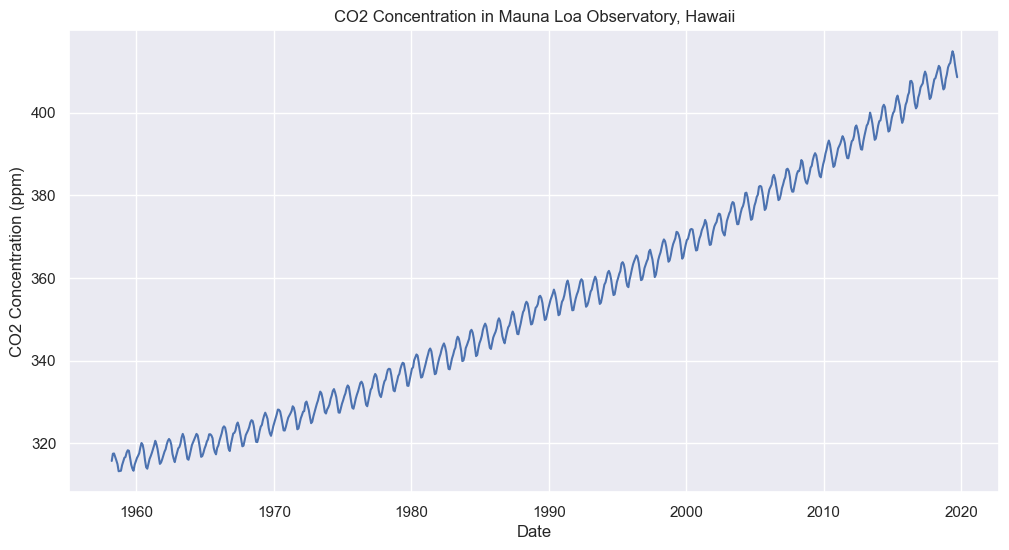

In [2]:
# Load the CO2.csv file
# - Skip the first 54 rows since they just contain metadata
df = pd.read_csv(
    './Datasets/CO2.csv',
    skiprows=54,
)

# The resulting column names have a lot of spaces in them.
# Let's remove them.
df.columns = df.columns.str.replace(' ', '')

# Parse the date column (in excel format) into a datetime object
# (We take the value in date as the number of days since 1899-12-30)
df['Date'] = pd.to_datetime(df['Date'], unit='D', origin='1899-12-30')

# We reset the index of the dataframe to have it start at 0
df = df.reset_index(drop=True)

# Calculate the values of the "t" column of the dataframe.
# ti = (i + 0.5) / 12, where i = 0 corresponds to Jan 1958.
df['t'] = (np.array(list(df.index)) + 0.5) / 12

# For a time series we only need the following columns:
# (We use iloc because there are multiple CO2 columns)
# - Date (2)
# - CO2 (3)
# - t (9)
# - month or Mn (1)
ts = df.iloc[:, [1, 2, 3, 9]]

# Pre processing: Drop all CO2 values that are recorded as -99.99
# (This is the value used to indicate missing data)
print("Shape before dropping missing values: ", ts.shape)
ts = ts[ts['CO2'] != -99.99]
ts = ts.dropna()
ts = ts.reset_index(drop=True)
print("Shape after dropping missing values: ", ts.shape)

# ============== TIME SERIES ARRAY ============= #

# Turn the time series into a 2D array
ts_array = ts.values

# ==================== PLOT ==================== #

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts['Date'], ts['CO2'])
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Concentration in Mauna Loa Observatory, Hawaii')
plt.show()

### Train Test Split


In [3]:
# Split the data into a 80/20 train/test split.
# - Column 3: "t" column (y)
# - Column 2: CO2 concentration (X)
# - Column 1: Full date (not used here)
# - Column 0: Month (not used here)
X_train, X_test, y_train, y_test = train_test_split(
    ts_array[:, 3],
    ts_array[:, 2],
    test_size=0.2,
    shuffle=False,
    random_state=42,
)

# Flatten the arrays
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### Fitting a Linear Model


Intercept (alpha 0):  308.9916567323666
Slope (alpha 1):  1.4066911494215175


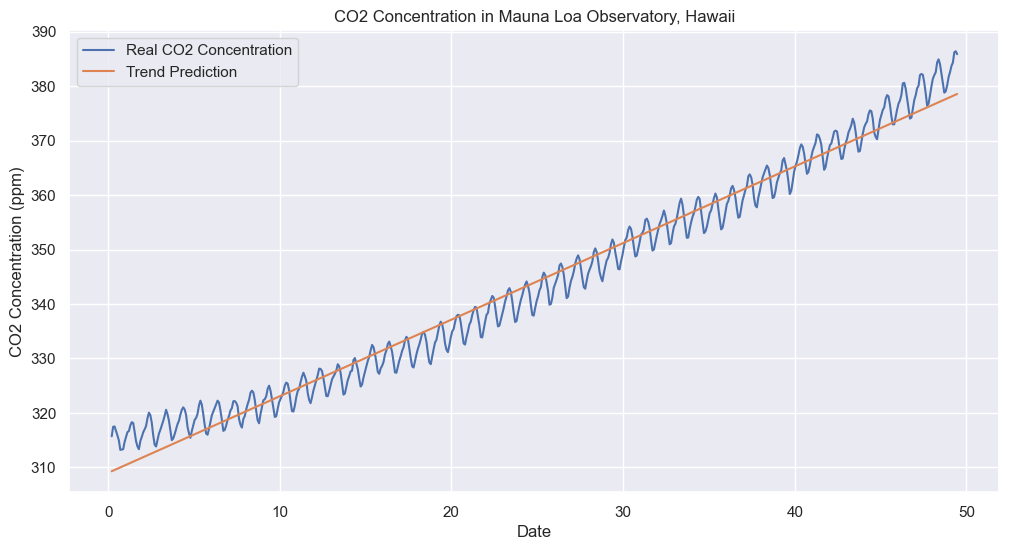

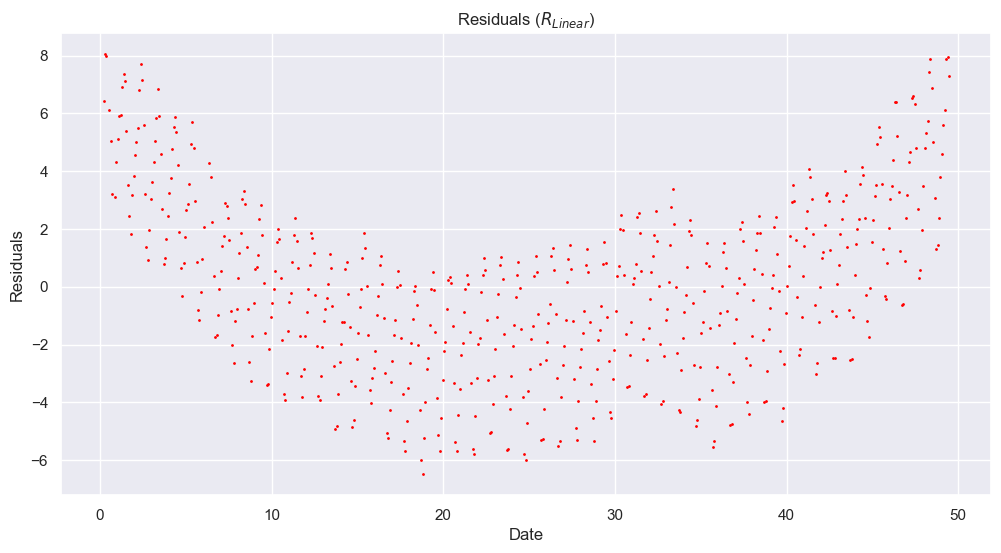

Manual RMSE:  10.641458521874679
Sklearn RMSE:  10.641458521874677
Manual MAPE:  2.450454956443145 %
Sklearn MAPE:  2.450454956443145 %


In [4]:
# Use the sklearn linear regression model to fit the data trend
linear_model = LinearRegression()
trend_fit = linear_model.fit(X_train, y_train)

# We predict the trend line using the same data
y_pred_train = trend_fit.predict(X_train)

# Get the slope and intercept of the trend line
slope = trend_fit.coef_[0][0]
intercept = trend_fit.intercept_[0]
print("Intercept (alpha 0): ", intercept)
print("Slope (alpha 1): ", slope)

# ============== TREND PREDICTION ============== #

# Plot the trend line with the data
plt.figure(figsize=(12, 6))
plt.plot(
    X_train,
    y_train,
    label='Real CO2 Concentration',
)
plt.plot(
    X_train,
    y_pred_train,
    label='Trend Prediction',
)

plt.legend()
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Concentration in Mauna Loa Observatory, Hawaii')
plt.show()

# ================== RESIDUALS ================= #

# Calculate the residuals
residuals = y_train - y_pred_train

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(X_train, residuals, color='red', s=1)
plt.xlabel('Date')
plt.ylabel("Residuals")
plt.title("Residuals ($R_{Linear}$)")
plt.show()

# ================ RMSE AND MAPE =============== #

# Generate a prediction for the test set
y_pred_test = trend_fit.predict(X_test)

# Calculate the RMSE
# (Root mean squared error)
rmse = mean_squared_error(
    y_test,
    y_pred_test,
    squared=False,
)

# Calculate the RMSE manually
manual_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))

# Print the RMSE
print("Manual RMSE: ", rmse)
print(f"Sklearn RMSE: ", manual_rmse)

# Calculate the MAPE
# (Mean absolute percentage error)
sklearn_mape = mean_absolute_percentage_error(
    y_test,
    y_pred_test,
)

# Calculate the MAPE manually
manual_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Print the MAPE
print(f"Manual MAPE: ", manual_mape, "%")
print("Sklearn MAPE: ", sklearn_mape*100, "%")

### Fitting a Quadratic Model


Intercept (beta 0):  314.1005841870842
Slope (beta 1):  0.8020970211603151
Quadratic term (beta 2):  0.012117499698121164


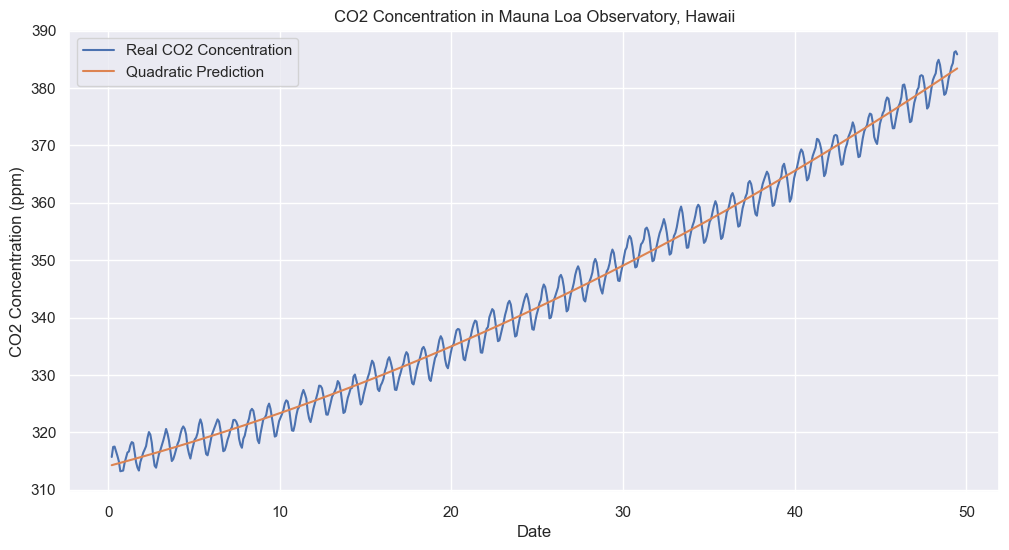

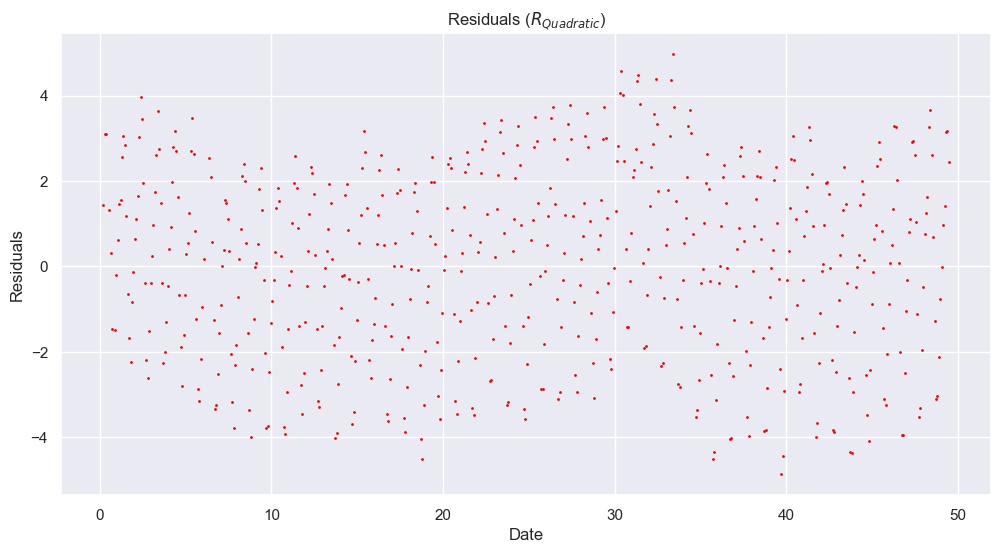

Sklearn RMSE:  2.501332219489783
Manual RMSE:  2.5013322194897825
Sklearn MAPE:  0.5320319129740851 %


In [5]:
# Create an array with "t" in the first column and
# "t^2" in the second column
X_train_quadratic = np.hstack((X_train, X_train ** 2))

# Fit a linear model to "t", "t^2" and the CO2 concentration
linear_model = LinearRegression().fit(
    X_train_quadratic,
    y_train,
)

# Predict the CO2 concentration using the quadratic model
y_pred_train_quadratic = linear_model.predict(X_train_quadratic)

# Get the coefficients of the quadratic model
beta_0 = linear_model.intercept_[0]
beta_1 = linear_model.coef_[0][0]
beta_2 = linear_model.coef_[0][1]
print("Intercept (beta 0): ", beta_0)
print("Slope (beta 1): ", beta_1)
print("Quadratic term (beta 2): ", beta_2)

# ============== QUADRATIC PREDICTION ============== #

# Plot the quadratic model with the data
plt.figure(figsize=(12, 6))
plt.plot(
    X_train,
    y_train,
    label='Real CO2 Concentration',
)
plt.plot(
    X_train,
    y_pred_train_quadratic,
    label='Quadratic Prediction',
)

plt.legend()
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Concentration in Mauna Loa Observatory, Hawaii')
plt.show()

# ================== RESIDUALS ================= #

# Calculate the residuals
residuals = y_train - y_pred_train_quadratic

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(X_train, residuals, color='red', s=1)
plt.xlabel('Date')
plt.ylabel("Residuals")
plt.title("Residuals ($R_{Quadratic}$)")
plt.show()

# ================ RMSE AND MAPE =============== #

# Generate a prediction for the test set
X_test_quadratic = np.hstack((X_test, X_test ** 2))
y_pred_test_quadratic = linear_model.predict(X_test_quadratic)

# Calculate the RMSE
# (Root mean squared error)
quadratic_trend_rmse = mean_squared_error(
    y_test,
    y_pred_test_quadratic,
    squared=False,
)

# Calculate the RMSE manually
manual_rmse = np.sqrt(np.mean((y_test - y_pred_test_quadratic) ** 2))

# Print the RMSE
print(f"Sklearn RMSE: ", quadratic_trend_rmse)
print("Manual RMSE: ", manual_rmse)

# Calculate the MAPE
# (Mean absolute percentage error)
quadratic_trend_mape = mean_absolute_percentage_error(
    y_test,
    y_pred_test_quadratic,
)

# Print the MAPE
print("Sklearn MAPE: ", quadratic_trend_mape*100, "%")

### Fitting a Cubic Model


Intercept (gamma 0):  314.8585261562889
Slope (gamma 1):  0.6248954085886231
Quadratic term (gamma 2):  0.020957567397565685
Cubic term (gamma 3):  -0.00011832339739602932


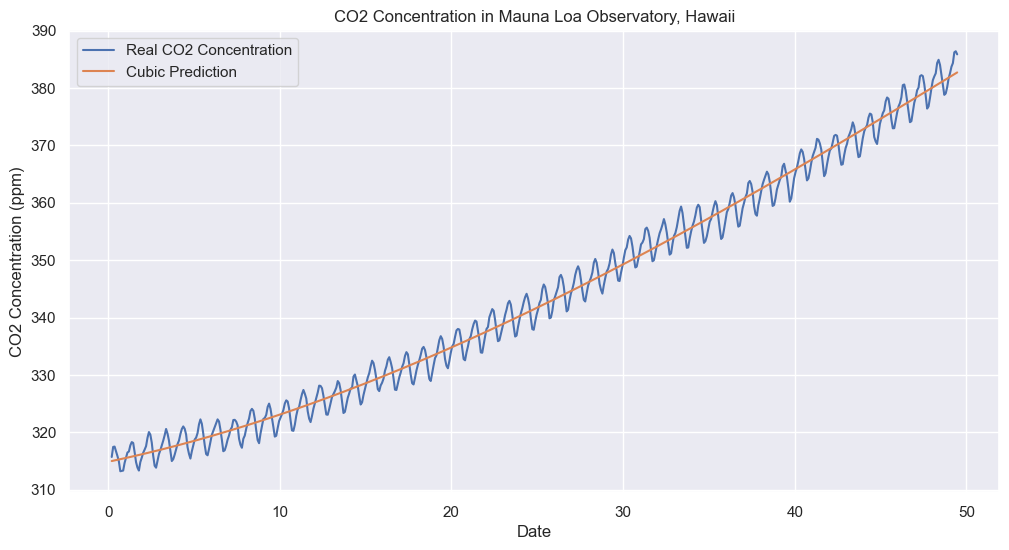

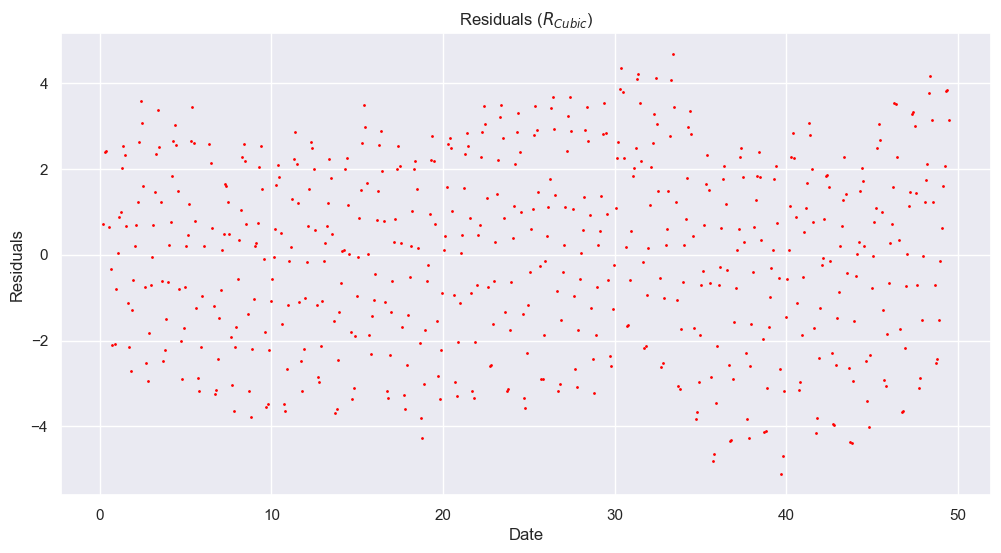

Sklearn RMSE:  4.149370712134371
Manual RMSE:  4.14937071213437
Sklearn MAPE:  0.8483502723896401 %


In [6]:
# Create an array with "t" in the first column,
# "t^2" in the second column and "t^3" in the third column
X_train_cubic = np.hstack((X_train, X_train ** 2, X_train ** 3))

# Fit a linear model to "t", "t^2", "t^3" and the CO2 concentration
linear_model = LinearRegression().fit(
    X_train_cubic,
    y_train,
)

# Predict the CO2 concentration using the cubic model
y_pred_train_cubic = linear_model.predict(X_train_cubic)

# Get the coefficients of the cubic model
gamma_0 = linear_model.intercept_[0]
gamma_1 = linear_model.coef_[0][0]
gamma_2 = linear_model.coef_[0][1]
gamma_3 = linear_model.coef_[0][2]
print("Intercept (gamma 0): ", gamma_0)
print("Slope (gamma 1): ", gamma_1)
print("Quadratic term (gamma 2): ", gamma_2)
print("Cubic term (gamma 3): ", gamma_3)

# ============== CUBIC PREDICTION ============== #

# Plot the cubic model with the data
plt.figure(figsize=(12, 6))
plt.plot(
    X_train,
    y_train,
    label='Real CO2 Concentration',
)
plt.plot(
    X_train,
    y_pred_train_cubic,
    label='Cubic Prediction',
)

plt.legend()
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Concentration in Mauna Loa Observatory, Hawaii')
plt.show()

# ================== RESIDUALS ================= #

# Calculate the residuals
residuals = y_train - y_pred_train_cubic

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(X_train, residuals, color='red', s=1)
plt.xlabel('Date')
plt.ylabel("Residuals")
plt.title("Residuals ($R_{Cubic}$)")
plt.show()

# ================ RMSE AND MAPE =============== #

# Generate a prediction for the test set
X_test_cubic = np.hstack((X_test, X_test ** 2, X_test ** 3))
y_pred_test_cubic = linear_model.predict(X_test_cubic)

# Calculate the RMSE
# (Root mean squared error)
rmse = mean_squared_error(
    y_test,
    y_pred_test_cubic,
    squared=False,
)

# Calculate the RMSE manually
manual_rmse = np.sqrt(np.mean((y_test - y_pred_test_cubic) ** 2))

# Print the RMSE
print(f"Sklearn RMSE: ", rmse)
print("Manual RMSE: ", manual_rmse)

# Calculate the MAPE
# (Mean absolute percentage error)
sklearn_mape = mean_absolute_percentage_error(
    y_test,
    y_pred_test_cubic,
)

# Print the MAPE
print("Sklearn MAPE: ", sklearn_mape*100, "%")

### Fitting a Periodic Signal


In [7]:
# Select the polynomial trend with the lowest degree
# that is able to represent the trend found in the data
train_trend = y_pred_train_quadratic
test_trend = y_pred_test_quadratic

# Calculate the residuals
train_residuals = y_train - train_trend
test_residuals = y_test - test_trend

# Join the train and test residuals
residuals = np.concatenate((train_residuals, test_residuals))

# Get the month of each residual from ts_array
# (The first column in ts_array is the month or a range from 1 to 12)
months = ts_array[:, 0]

# Generate a two column array with the month and the residual
residuals_array = np.column_stack((months, residuals))

# Create a dataframe with the residuals array
residuals_df = pd.DataFrame(
    residuals_array,
    columns=['Month', 'Residuals'],
)

# We fetch the residuals for the test set (the last 20% of the data)
residuals_df_test = residuals_df.iloc[-int(0.2 * len(residuals_df)):]

# We fetch the residuals for the train set (the last 80% of the data)
residuals_df_train = residuals_df.iloc[:int(0.8 * len(residuals_df))]

# Average the residuals by month for the
# - train set
# - test set
# - full set
residuals_df_train = residuals_df_train.groupby('Month').mean()
residuals_df_test = residuals_df_test.groupby('Month').mean()
residuals_df = residuals_df.groupby('Month').mean()

# Flatten the columns of both the train and test dataframes
residuals_df_train = residuals_df_train.reset_index()
residuals_df_test = residuals_df_test.reset_index()
residuals_df = residuals_df.reset_index()

# Print the results
print("[X] Residuals by month for the train set:")
print("(This is the one to use in your answer to the question)")
print(residuals_df_train.iloc[0:2, :])
print()

print("[ ] Residuals by month for the test set:")
print(residuals_df_test.iloc[0:2, :])
print()

print("[ ] Residuals by month for the full set:")
print(residuals_df.iloc[0:2, :])

[X] Residuals by month for the train set:
(This is the one to use in your answer to the question)
   Month  Residuals
0      1  -0.012919
1      2   0.646407

[ ] Residuals by month for the test set:
   Month  Residuals
0      1   0.966717
1      2   1.508454

[ ] Residuals by month for the full set:
   Month  Residuals
0      1   0.179796
1      2   0.818816


### The Final Model

(3 points) Plot the periodic signal Pi. (Your plot should have 1 data point for each month, so 12 in total.) Clearly state the definition the Pi, and make sure your plot is clearly labeled.

Python tip: For interpolation, you may use interp1d from Scikit-learn. See Documentation on `interp1d`.


Pi Shape: (12, 2)


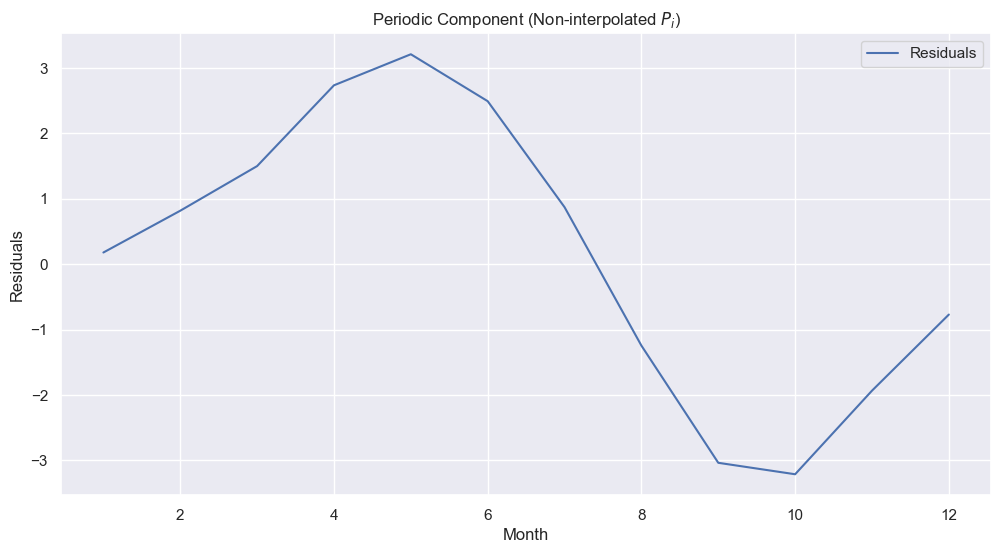

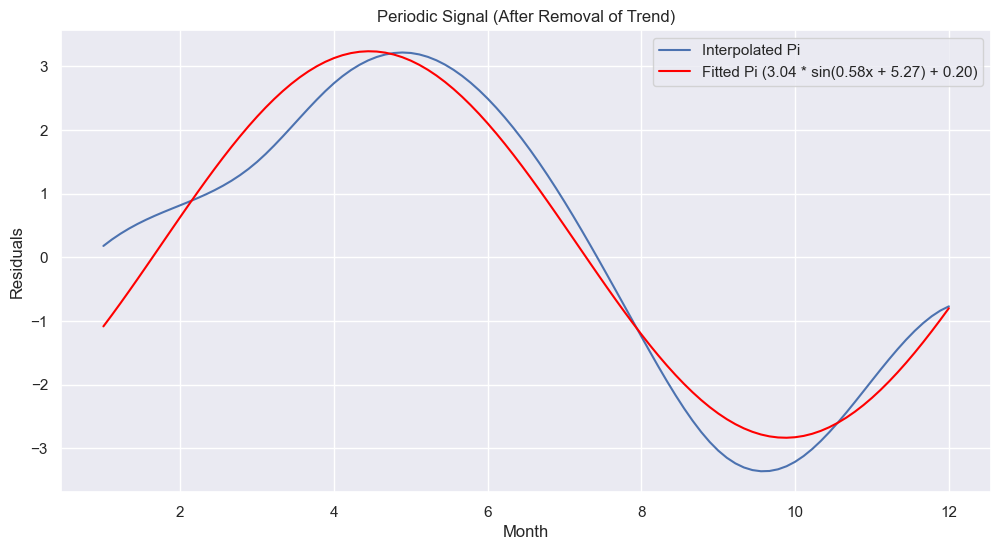

In [8]:
# Rename the "residuals_df" to the name used in the instructions: Pi
Pi = residuals_df.copy()

# Check the dimensions of Pi
# (Should be 12 rows and 2 columns)
print("Pi Shape:", Pi.shape)

# We have 1 row for each month and two columns (the month and the residuals)
# Plot the residuals by month
plt.figure(figsize=(12, 6))
plt.plot(
    Pi['Month'],
    Pi['Residuals'],
    label='Residuals',
)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.title('Periodic Component (Non-interpolated $P_i$)')
plt.show()

# ================ INTERPOLATION =============== #

# Generate an array with a 100 values between 1 and 12
Pi_interpolated_month = np.linspace(1, 12, 100)

# Generate a function that interpolates the residuals
# (Under the hood, scipy uses scipy's interp1d function)
Pi_interpolated_function = interp1d(
    Pi['Month'],
    Pi['Residuals'],
    kind='cubic',
)

# Generate the interpolated residuals
Pi_interpolated_residuals = Pi_interpolated_function(
    Pi_interpolated_month,
)

# ========== PI THEORETICAL DEFINITION ========= #


def periodic_function(x, amplitude, period, phase, bias):
    """
    A sinusoidal function with the following parameters:
    - amplitude: The amplitude of the sinusoidal function
    - period: The period of the sinusoidal function
    - phase: The phase of the sinusoidal function
    - bias: The bias of the sinusoidal function 

    Used to fit the periodic component of the time series.
    """

    return amplitude * np.sin(x*period + phase) + bias


# Fit the periodic component
optimal_params, _ = curve_fit(
    periodic_function,
    Pi_interpolated_month,
    Pi_interpolated_residuals,
)

# ============= INTERPOLATION PLOT ============= #

plt.figure(figsize=(12, 6))
plt.plot(
    Pi_interpolated_month,
    Pi_interpolated_residuals,
    label='Interpolated Pi',
)
plt.plot(
    Pi_interpolated_month,
    periodic_function(
        Pi_interpolated_month,
        *optimal_params,
    ),
    label=f'Fitted Pi ({optimal_params[0]:.2f} * sin({optimal_params[1]:.2f}x + {optimal_params[2]:.2f}) + {optimal_params[3]:.2f})',
    color='red',
)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.title('Periodic Signal (After Removal of Trend)')
plt.show()

(2 points) Plot the final fit $F_ n(t_ i) + P_ i$. Your plot should clearly show the final model on top of the entire time series, while indicating the split between the training and testing data.


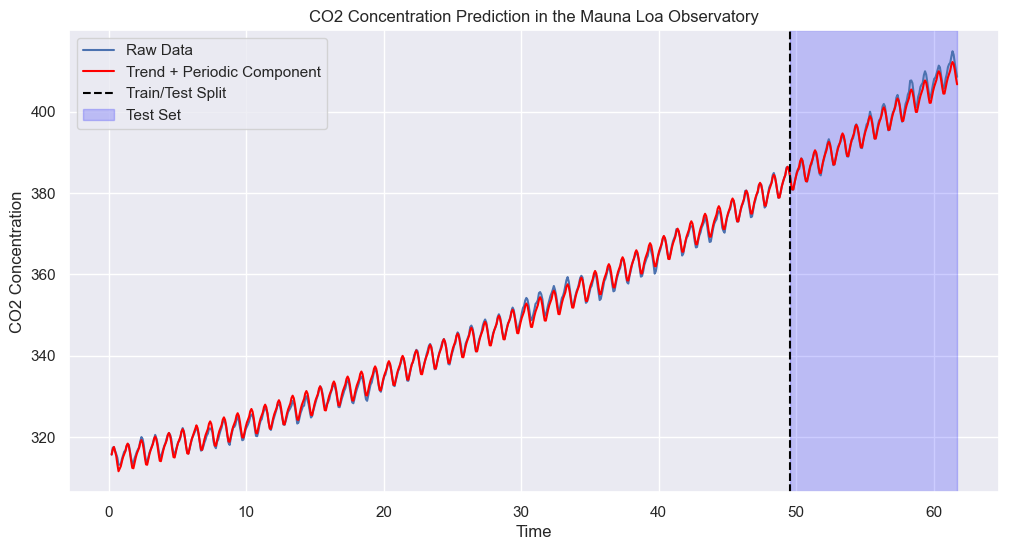

In [9]:
# Get the ts and C02 measurements from ts_array
ts = ts_array[:, 3]
concentration = ts_array[:, 2]

# Trend Component
trend = np.concatenate((train_trend, test_trend))
trend = trend.flatten()

# Periodic Component
# Pi contains the residuals for each month in the year. We need to match the
# values of Pi with the months in the ts_array.
months = ts_array[:, 0]

# We need to create a list of the same length as the ts_array
periodic = np.array([
    Pi[Pi['Month'] == month]['Residuals'].values[0] for month in months
])

# Get the number of samples
n_samples = len(ts)
n_train_samples = math.floor(0.8 * n_samples)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(
    ts,
    concentration,
    label='Raw Data',
)
plt.plot(
    ts,
    trend + periodic,
    label='Trend + Periodic Component',
    color='red',
)
plt.axvline(
    x=ts[n_train_samples],
    color='black',
    linestyle='--',
    label='Train/Test Split',
)

# Shade the region after the train/test split. It should start in
# the 80% of the data and end in the 100% of the data, while spanning
# the entire y-axis.
plt.axvspan(
    ts[n_train_samples],
    ts[-1],
    alpha=0.2,
    color='blue',
    label='Test Set',
)

plt.legend()
plt.xlabel('Time')
plt.ylabel('CO2 Concentration')
plt.title('CO2 Concentration Prediction in the Mauna Loa Observatory')
plt.show()

(4 points) Report the root mean squared prediction error RMSE and the mean absolute percentage error MAPE with respect to the test set for this final model. Is this an improvement over the previous model $F_ n(t_ i)$ without the periodic signal? (Maximum 200 words.)


In [10]:
# Generate the final fit (trend + periodic)
final_fit = trend + periodic

# Get the test section of the final fit (the last 20% of the data)
n_test_samples = n_samples - n_train_samples
y_final_fit_test = final_fit[-n_test_samples:]

# Calculate the RMSE
# (Root mean squared error)
rmse = mean_squared_error(
    y_test,
    y_final_fit_test,
    squared=False,
)

# Calculate the MAPE
# (Mean absolute percentage error)
mape = mean_absolute_percentage_error(
    y_test,
    y_final_fit_test,
)

print("Trend + Periodic Component")
print(f"RMSE: ", rmse)
print("MAPE: ", mape*100, "%")
print()

print("Trend")
print(f"RMSE: ", quadratic_trend_rmse)
print("MAPE: ", quadratic_trend_mape*100, "%")
print()

print("Percentage Difference")
print(f"RMSE: ", (quadratic_trend_rmse - rmse) / quadratic_trend_rmse * 100, "%")
print("MAPE: ", (quadratic_trend_mape - mape) / quadratic_trend_mape * 100, "%")

Trend + Periodic Component
RMSE:  1.054729182725852
MAPE:  0.1911171270127314 %

Trend
RMSE:  2.501332219489783
MAPE:  0.5320319129740851 %

Percentage Difference
RMSE:  57.83330280929281 %
MAPE:  64.07788285774494 %


(3 points) What is the ratio of the range of values of $F$ to the amplitude of $P_i$ and the ratio of the amplitude of $P_i$ to the range of the residual $R_i$ (from removing both the trend and the periodic signal)? Is this decomposition of the variation of the $CO_2$ concentration meaningful? (Maximum 200 words.)


Amplitude: 6.42
F range: 95.47
R range: 4.65
Train ts max: 49.46
Test ts min: 49.54
Test ts max: 61.71


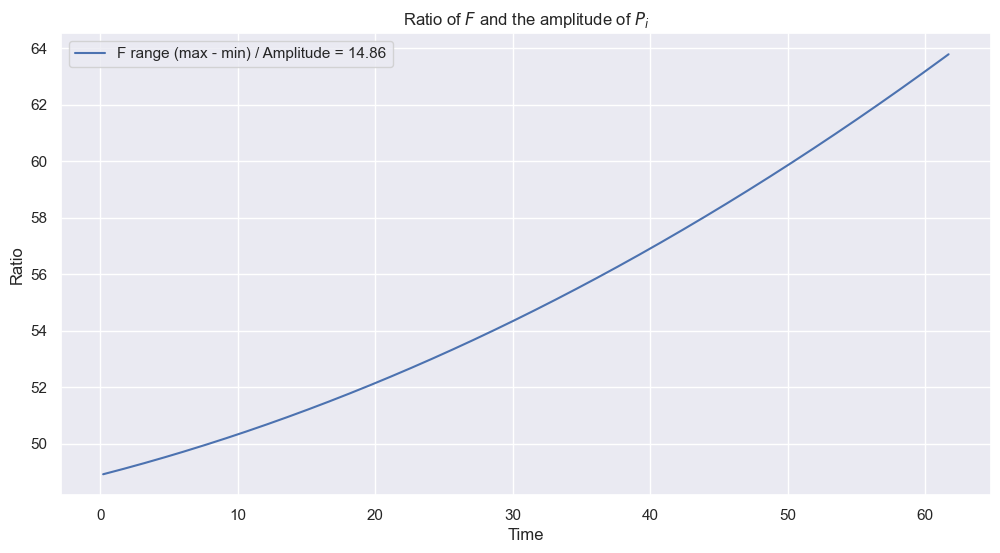

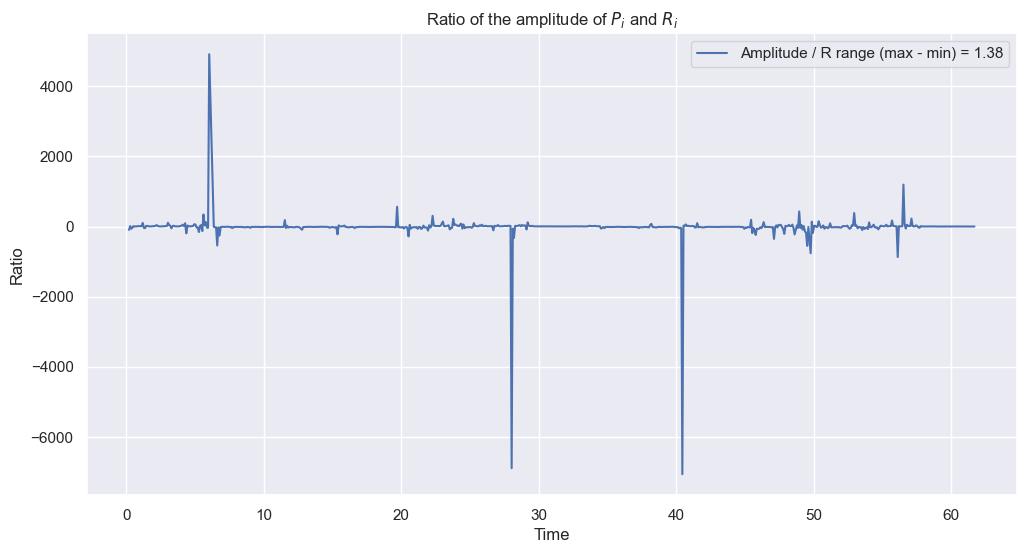

In [25]:
# Values to use
F = trend.copy()
P = periodic.copy()
CO2 = concentration.copy()

# Calculate the residuals
residuals = CO2 - F - P

# Get the amplitude of the periodic component
amplitude = np.max(P) - np.min(P)
F_range = np.max(F) - np.min(F)
R_range = np.max(residuals) - np.min(residuals)

print(f"Amplitude: {amplitude:.2f}")
print(f"F range: {F_range:.2f}")
print(f"R range: {R_range:.2f}")

# Get the number of samples in the training and test sets
n_samples = len(ts)
n_train_samples = math.floor(0.8 * n_samples)
n_test_samples = n_samples - n_train_samples

# Get the:
# - highest "ts" value in the training set
# - lowest "ts" value in the test set
# - highest "ts" value in the test set
train_ts_max = ts[n_train_samples - 1]
test_ts_min = ts[n_train_samples]
test_ts_max = ts[-1]
print(f"Train ts max: {train_ts_max:.2f}")
print(f"Test ts min: {test_ts_min:.2f}")
print(f"Test ts max: {test_ts_max:.2f}")


# Ratios
F_range_amplitude_ratio = F_range / amplitude
amplitude_R_range_ratio = amplitude / R_range

# Calculate the ratio for all points in both F and the residuals
F_ratio = F / amplitude
R_ratio = amplitude / residuals

# ==================== PLOTS =================== #

# Ratio: F range / Amplitude
plt.figure(figsize=(12, 6))
plt.plot(
    ts,
    F_ratio,
    label=f"F range (max - min) / Amplitude = {F_range_amplitude_ratio:.2f}"
)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Ratio of $F$ and the amplitude of $P_i$')
plt.show()

# Ratio: Amplitude / R range
plt.figure(figsize=(12, 6))
plt.plot(
    ts,
    R_ratio,
    label=f"Amplitude / R range (max - min) = {amplitude_R_range_ratio:.2f}"
)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Ratio of the amplitude of $P_i$ and $R_i$')
plt.show()
